In [1]:
import numpy as np

class LinearRegressionFromScratch:
    """
    A custom implementation of Linear Regression using Gradient Descent.
    
    Attributes:
    -----------
    learning_rate : float
        The step size for gradient descent optimization.
    n_iterations : int
        The number of passes over the training data (epochs).
    weights : numpy.ndarray
        The coefficients (slopes) of the regression model.
    bias : float
        The intercept of the regression model.
    """
    
    def __init__(self, learning_rate=0.001, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.cost_history = [] # To verify convergence later

    def fit(self, X, y):
        """
        Fit the linear regression model to the training data.
        
        Parameters:
        -----------
        X : numpy.ndarray, shape (n_samples, n_features)
            The training input samples.
        y : numpy.ndarray, shape (n_samples,)
            The target values.
        """
        # Initialize parameters
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient Descent Loop
        for i in range(self.n_iterations):
            # 1. Prediction (Hypothesis): y_hat = wX + b
            y_predicted = np.dot(X, self.weights) + self.bias

            # 2. Calculate Gradients
            # Derivative with respect to weights: (2/n) * X.T * (y_hat - y)
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            # Derivative with respect to bias: (2/n) * sum(y_hat - y)
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # 3. Update Parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Optional: Record cost to visualize convergence
            cost = np.mean((y_predicted - y) ** 2)
            self.cost_history.append(cost)

    def predict(self, X):
        """
        Predict target values using the learned parameters.
        
        Parameters:
        -----------
        X : numpy.ndarray
            The input samples.
            
        Returns:
        --------
        numpy.ndarray
            Predicted values.
        """
        return np.dot(X, self.weights) + self.bias

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Setting a seed for reproducibility
np.random.seed(42)

# Simulating Agro Data
# n_samples = 100 farms
# Feature 1: Rainfall in mm (random between 800 and 1500)
rainfall = np.random.randint(800, 1500, 100)
# Feature 2: Fertilizer in kg/ha (random between 50 and 300)
fertilizer = np.random.randint(50, 300, 100)

# Target: Crop Yield in tons/ha
# We create a linear relationship with some noise (randomness)
# Yield = 2 + 0.005*Rainfall + 0.02*Fertilizer + Noise
true_bias = 2
true_weights = np.array([0.005, 0.02])
noise = np.random.normal(0, 0.5, 100)

X_agro = np.column_stack((rainfall, fertilizer))
y_agro = true_bias + (rainfall * true_weights[0]) + (fertilizer * true_weights[1]) + noise

# Visualize the first few rows as a DataFrame
df_agro = pd.DataFrame(X_agro, columns=['Rainfall_mm', 'Fertilizer_kg_ha'])
df_agro['Yield_ton_ha'] = y_agro

print("Agro Dataset Sample:")
print(df_agro.head())

Agro Dataset Sample:
   Rainfall_mm  Fertilizer_kg_ha  Yield_ton_ha
0          902               130      9.746867
1         1235               185     11.729024
2         1070               212     10.262412
3          906               212     10.942759
4          871                82      7.797242


Weights (from scratch): [0.98605348 1.52582627]
Bias (from scratch): 11.298217513103978


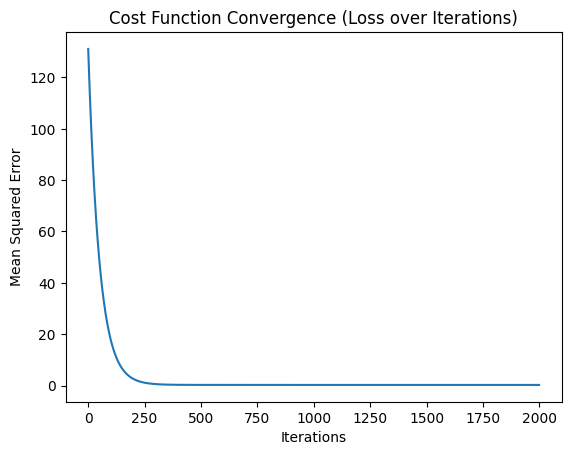

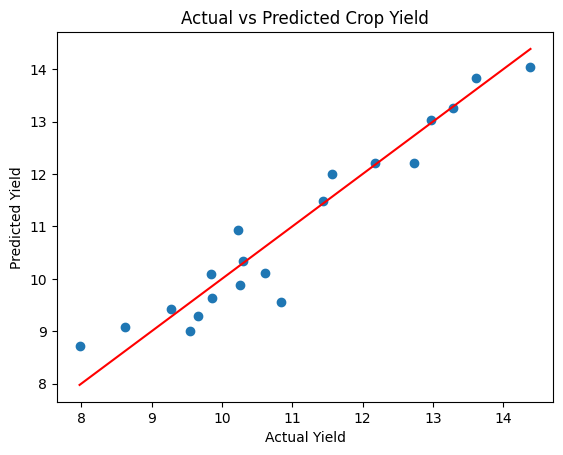

In [3]:
# 1. Split data (Simple split for demonstration)
# Ideally, implement a train_test_split function from scratch too!
train_size = int(0.8 * len(X_agro))
X_train, X_test = X_agro[:train_size], X_agro[train_size:]
y_train, y_test = y_agro[:train_size], y_agro[train_size:]

# Scale the data (Crucial for Gradient Descent stability!)
# Simple Min-Max scaling manually implemented
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std

# 2. Train the model
model = LinearRegressionFromScratch(learning_rate=0.01, n_iterations=2000)
model.fit(X_train_scaled, y_train)

# 3. Make predictions
predictions = model.predict(X_test_scaled)

# 4. Compare results
print(f"Weights (from scratch): {model.weights}")
print(f"Bias (from scratch): {model.bias}")

# Plotting Convergence
plt.plot(model.cost_history)
plt.title('Cost Function Convergence (Loss over Iterations)')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.show()

# Plotting Predictions vs Actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Actual vs Predicted Crop Yield')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Diagonal line
plt.show()

In [4]:
# ==========================================
# COMPARAÇÃO: Custom Implementation vs Scikit-Learn
# ==========================================

from sklearn.linear_model import LinearRegression

# 1. Treinar o modelo padrão do mercado (Scikit-Learn)
# O scikit-learn usa OLS (Solução Fechada), não Gradient Descent por padrão
sklearn_model = LinearRegression()
sklearn_model.fit(X_train_scaled, y_train)

# 2. Extrair os coeficientes
# Nota: O scikit separa coeficientes (pesos) do intercepto (viés)
sklearn_weights = sklearn_model.coef_
sklearn_bias = sklearn_model.intercept_

# 3. Mostrar Comparação Lado a Lado
print(f"{'PARAM':<15} | {'SEU MODELO (Gradient Descent)':<30} | {'SKLEARN (OLS/Standard)':<25}")
print("-" * 75)
print(f"{'Bias (Intercept)':<15} | {model.bias:<30.5f} | {sklearn_bias:<25.5f}")

for i in range(len(model.weights)):
    print(f"{f'Weight_{i}':<15} | {model.weights[i]:<30.5f} | {sklearn_weights[i]:<25.5f}")

print("-" * 75)

# 4. Verificação de Erro (MSE) nos dados de teste
from sklearn.metrics import mean_squared_error

# Previsões
preds_custom = model.predict(X_test_scaled)
preds_sklearn = sklearn_model.predict(X_test_scaled)

mse_custom = mean_squared_error(y_test, preds_custom)
mse_sklearn = mean_squared_error(y_test, preds_sklearn)

print(f"\nMSE (Erro Quadrático Médio) - Seu Modelo: {mse_custom:.5f}")
print(f"MSE (Erro Quadrático Médio) - Scikit-Learn: {mse_sklearn:.5f}")

if abs(mse_custom - mse_sklearn) < 0.1:
    print("\n✅ SUCESSO! Seu modelo convergiu para o mesmo resultado do Scikit-Learn.")
else:
    print("\n⚠️ ATENÇÃO! A diferença está grande. Tente aumentar 'n_iterations' ou ajustar 'learning_rate'.")

PARAM           | SEU MODELO (Gradient Descent)  | SKLEARN (OLS/Standard)   
---------------------------------------------------------------------------
Bias (Intercept) | 11.29822                       | 11.29822                 
Weight_0        | 0.98605                        | 0.98605                  
Weight_1        | 1.52583                        | 1.52583                  
---------------------------------------------------------------------------

MSE (Erro Quadrático Médio) - Seu Modelo: 0.22659
MSE (Erro Quadrático Médio) - Scikit-Learn: 0.22659

✅ SUCESSO! Seu modelo convergiu para o mesmo resultado do Scikit-Learn.
